# *Logistic Regression Model: Top 500 customers by churn risk*

In [79]:
# Step 1: Import libraries, Read in the data, Introduce some handy functions

# import the big 4
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Import performance metrics
from sklearn import metrics
from time import time

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score

## Import Logistic Regression from sklearn
from sklearn.linear_model import LogisticRegression

# Import ensemble models
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Accurancy, precision, recall function

def apr(y_pred, y_real):
    accuracy = metrics.accuracy_score(y_real, y_pred)
    precision = metrics.precision_score(y_real, y_pred)
    recall = metrics.recall_score(y_real, y_pred)
    f1 = metrics.f1_score(y_real, y_pred)
    
    print(f"Accuracy:{accuracy}")
    print(f"Precision:{precision}")
    print(f"Recall:{recall}")
    print(f"F1:{f1}")
    return accuracy, precision, recall, f1


## Confusion matrix function

def produce_confusion(positive_label, negative_label, cut_off, df, y_pred_name, y_real_name):
    
    #Set pred to 0 or 1 depending on whether it's higher than the cut_off point.
    
    if cut_off != 'binary':      
        df['pred_binary'] = np.where(df[y_pred_name] > cut_off , 1, 0)
    else: 
        df['pred_binary'] = df[y_pred_name]
    
    #Build the CM
    cm = confusion_matrix(df[y_real_name], df['pred_binary'])  
    
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, fmt='g'); 

    # labels, title, ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('Real labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels([negative_label, positive_label])
    ax.yaxis.set_ticklabels([negative_label, positive_label]);

    print('Test accuracy = ', accuracy_score(df[y_real_name], df['pred_binary']))

    return accuracy_score(df[y_real_name], df['pred_binary'])

df = pd.read_excel("1 - Project Data.xlsx")

dropped_customers = df[df['Total Charges'].str.strip() == '']

# Mapping columns to get binary results
def columns_binary(x):
    if x == 'Yes':
        return 1
    else:
        return 0


In [83]:
# Step 2: Feature Engineer & Train Test Split (data leakage avoided: no null-handling aggregations)
def feature_eng(df):

    # Drop rows where 'Total Charges' is missing or empty
    # We have 11 rows with empty Total Charges which we decided to drop rather than replace
    df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')  # Ensure 'Total Charges' is numeric
    df = df.dropna(subset=['Total Charges'])  # Drop rows with missing 'Total Charges'

    
    # Drop non-useful columns
    df = df.drop(columns = ['CustomerID', 
                            'Count', 
                            'Country',
                            'Zip Code',
                            'State', 
                            'Lat Long', 
                            'Latitude', 
                            'Longitude', 
                            'Churn Label',
                            'Churn Reason'],
                            axis = 1) # We already have Churn Value which is already a numerical 

    
    # Change yes/no(including: No internet/Phone services) to binary
    df['Senior Citizen'] = df['Senior Citizen'].apply(columns_binary)
    df['Partner'] = df['Partner'].apply(columns_binary)
    df['Dependents'] = df['Dependents'].apply(columns_binary)
    df['Phone Service'] = df['Phone Service'].apply(columns_binary)
    df['Paperless Billing'] = df['Paperless Billing'].apply(columns_binary)

    # Changing columns with only two results to numericals
    df['Gender'] = df['Gender'].map({'Male':0, 'Female':1})

    # Changing columns with 3 results to numericals
    df['Multiple Lines'] = df['Multiple Lines'].map({'No':0, 'Yes':1, 'No phone service':2})
    df['Online Security'] = df['Online Security'].map({'No':0, 'Yes':1, 'No internet service':2})
    df['Device Protection'] = df['Device Protection'].map({'No':0, 'Yes':1, 'No internet service':2})
    df['Online Backup'] = df['Online Backup'].map({'No':0, 'Yes':1, 'No internet service':2})
    df['Tech Support'] = df['Tech Support'].map({'No':0, 'Yes':1, 'No internet service':2})
    df['Streaming TV'] = df['Streaming TV'].map({'No':0, 'Yes':1, 'No internet service':2})
    df['Streaming Movies'] = df['Streaming Movies'].map({'No':0, 'Yes':1, 'No internet service':2})

    
    # OHE columns
    df = pd.get_dummies(df, columns = ['Internet Service'], drop_first = True, prefix = 'Internet Service', dtype=int)
    df = pd.get_dummies(df, columns = ['Contract'], drop_first = True, prefix = 'Contract', dtype=int)
    df = pd.get_dummies(df, columns = ['Payment Method'], drop_first = True, prefix = 'Payment Method', dtype=int)

    # Map cities to unique integers
    city_mapping = {city: idx for idx, city in enumerate(df['City'].unique())}
    df['City'] = df['City'].map(city_mapping)

    return df


featured_df = feature_eng(df)


# Define feature columns for our predictions
feature_cols = ['City', 'Senior Citizen', 'Partner', 'Dependents',
               'Tenure Months', 'Online Security',
               'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
               'Streaming Movies', 'Paperless Billing', 'Monthly Charges',
               'Total Charges', 'Internet Service_Fiber optic',
               'Internet Service_No', 'Contract_One year', 'Contract_Two year',
               'Payment Method_Credit card (automatic)',
               'Payment Method_Electronic check', 'Payment Method_Mailed check'
               ]


X_train, X_test, y_train, y_test = train_test_split(featured_df[feature_cols],
                                                   featured_df['Churn Value'],
                                                   test_size = 0.3,
                                                   random_state = 99,
                                                   stratify = featured_df['Churn Value'])


In [ ]:

# def feature_eng(df):

#     # Drop rows where 'Total Charges' is missing or empty
#     # We have 11 rows with empty Total Charges which we decided to drop rather than replace
#     df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')  # Ensure 'Total Charges' is numeric
#     df = df.dropna(subset=['Total Charges'])  # Drop rows with missing 'Total Charges'

    
#     # Drop non-useful columns
#     df = df.drop(columns = ['CustomerID', 
#                             'Count', 
#                             'Country',
#                             'Zip Code',
#                             'State', 
#                             'Lat Long', 
#                             'Latitude', 
#                             'Longitude', 
#                             'Churn Label',
#                             'Churn Reason'],
#                             axis = 1) # We already have Churn Value which is already a numerical 

    
#     # Change yes/no(including: No internet/Phone services) to binary
#     df['Senior Citizen'] = df['Senior Citizen'].apply(columns_binary)
#     df['Partner'] = df['Partner'].apply(columns_binary)
#     df['Dependents'] = df['Dependents'].apply(columns_binary)
#     df['Phone Service'] = df['Phone Service'].apply(columns_binary)
#     df['Paperless Billing'] = df['Paperless Billing'].apply(columns_binary)

#     # Changing columns with only two results to numericals
#     df['Gender'] = df['Gender'].map({'Male':0, 'Female':1})

#     # Changing columns with 3 results to numericals
#     df['Multiple Lines'] = df['Multiple Lines'].map({'No':0, 'Yes':1, 'No phone service':2})
#     df['Online Security'] = df['Online Security'].map({'No':0, 'Yes':1, 'No internet service':2})
#     df['Device Protection'] = df['Device Protection'].map({'No':0, 'Yes':1, 'No internet service':2})
#     df['Online Backup'] = df['Online Backup'].map({'No':0, 'Yes':1, 'No internet service':2})
#     df['Tech Support'] = df['Tech Support'].map({'No':0, 'Yes':1, 'No internet service':2})
#     df['Streaming TV'] = df['Streaming TV'].map({'No':0, 'Yes':1, 'No internet service':2})
#     df['Streaming Movies'] = df['Streaming Movies'].map({'No':0, 'Yes':1, 'No internet service':2})

    
#     # OHE columns
#     df = pd.get_dummies(df, columns = ['Internet Service'], drop_first = True, prefix = 'Internet Service', dtype=int)
#     df = pd.get_dummies(df, columns = ['Contract'], drop_first = True, prefix = 'Contract', dtype=int)
#     df = pd.get_dummies(df, columns = ['Payment Method'], drop_first = True, prefix = 'Payment Method', dtype=int)

#     # Map cities to unique integers
#     city_mapping = {city: idx for idx, city in enumerate(df['City'].unique())}
#     df['City'] = df['City'].map(city_mapping)

#     return df


# featured_df = feature_eng(df)

/var/folders/0g/ynpg2bgn74d73bcv7xzr6nph0000gn/T/ipykernel_94801/323711388.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_target.values, y=correlation_with_target.index, palette='coolwarm')


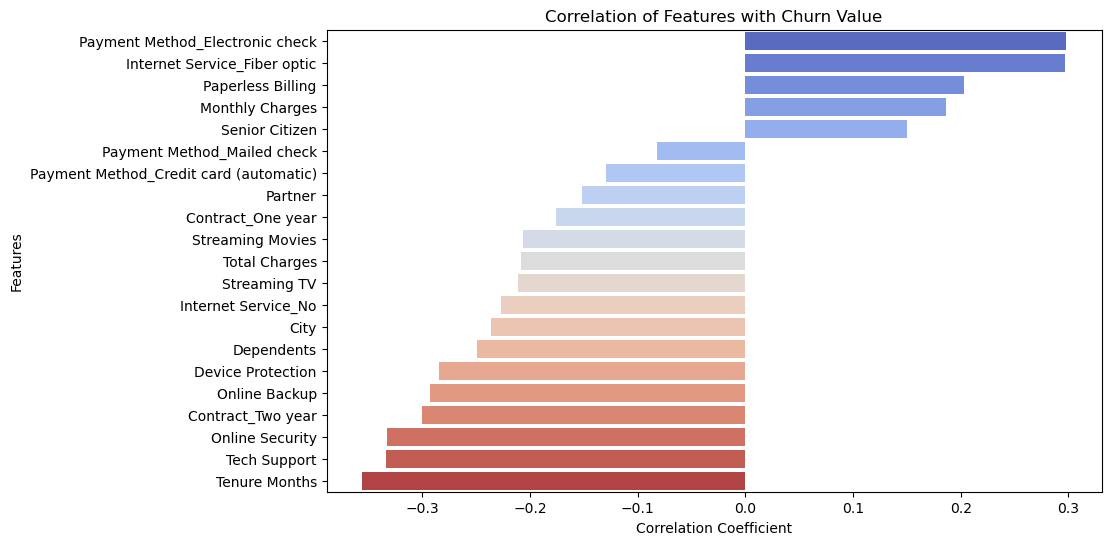

In [85]:
# Step 3: Visualise feature/target correlations
X_train['Churn Value'] = y_train

correlation_with_target = X_train.corr(numeric_only = True)['Churn Value'].drop('Churn Value').sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_target.values, y=correlation_with_target.index, palette='coolwarm')
plt.title('Correlation of Features with Churn Value')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

X_train = X_train.drop(columns=['Churn Value'])

In [87]:
# Step 4: Scaling 

columns_to_scale = ['Monthly Charges', 'Total Charges']
scaler = StandardScaler()
X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

In [89]:
# Step 5: Fit the model

lr = LogisticRegression(class_weight='balanced', max_iter=5000, random_state=99)
lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=5000, random_state=99)

In [91]:
## Step 6: Predict probabilities, store each binary prediction in a column corresponding to its class
X_train[['active', 'churned']] = lr.predict_proba(X_train)
X_train['y_pred'] = np.where(X_train['churned']>.3, 1, 0) # decision boundary of 0.3 to promote recall 

In [105]:
# Step 7: Evaluate model on test 

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Predictions
y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)[:, 1]

# Print metrics
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1202  347]
 [ 104  457]]
              precision    recall  f1-score   support

           0       0.92      0.78      0.84      1549
           1       0.57      0.81      0.67       561

    accuracy                           0.79      2110
   macro avg       0.74      0.80      0.76      2110
weighted avg       0.83      0.79      0.80      2110



In [107]:
def get_results(actual, predicted):
    print("The confusion matrix for your predictions is:")
    print(metrics.confusion_matrix(actual, predicted), "\n")
    print(f'The accuracy of your model is: {metrics.accuracy_score(actual, predicted)}')
    print(f'The recall of your model is: {metrics.recall_score(actual, predicted)}')
    print(f'The precision of your model is: {metrics.precision_score(actual, predicted)}')
    print(f'The F1-score of your model is: {metrics.f1_score(actual, predicted)}')

In [111]:
# Step 8: Check Performance Metrics
get_results(y_train, X_train['y_pred'])

The confusion matrix for your predictions is:
[[2214 1400]
 [  99 1209]] 

The accuracy of your model is: 0.6954490044697278
The recall of your model is: 0.9243119266055045
The precision of your model is: 0.4633959371406669
The F1-score of your model is: 0.6173091651774317


In [ ]:
# # EVALUATE ON TEST 
# columns_to_scale = ['Monthly Charges', 'Total Charges']
# scaler = StandardScaler()
# X_test[columns_to_scale] = scaler.fit_transform(X_test[columns_to_scale])
# X_test[['active', 'churned']] = lr.predict_proba(X_test)
# X_test['y_pred'] = np.where(X_test['churned']>.3, 1, 0)
# get_results(y_test, X_test['y_pred'])

In [23]:
# # Ensure only the original feature columns are passed to predict_proba
# X_test_clean = X_test[feature_cols]  # Use feature_cols as defined during train-test split

# # Predict probabilities
# y_pred_proba = lr.predict_proba(X_test_clean)[:, 1]  # Get the churn probabilities

# # Add the churn probabilities back to the original X_test
# X_test['churn_probability'] = y_pred_proba

# # Sort customers by churn probability
# X_test_sorted = X_test.sort_values(by='churn_probability', ascending=False)

# # Display the top 500 churners
# top_500_churners = X_test_sorted.head(500)
# top_500_churners.head(20)


In [115]:
# Step 9: Create list of Top 500 customers most likely to churn (from test set)

# Merge y_test (actual churn status) into X_test for clarity
X_test['actual_churn'] = y_test.values  # Add actual churn labels

# Predict probabilities for the feature set
X_test_clean = X_test[feature_cols] #extract feature columns from x_test
y_pred_proba = lr.predict_proba(X_test_clean)[:, 1] #predict probabilities for test

# Add churn probabilities back to the original X_test
X_test['churn_probability'] = y_pred_proba

# Filter for actives (Churn Value = 0)
actual_churners = X_test[X_test['actual_churn'] == 0]

# Sort by predicted churn probability
top_500_atrisk = actual_churners.sort_values(by='churn_probability', ascending=False).head(500)

# Display the top 20 churners
top_500_atrisk.head(5)

,City,Senior Citizen,Partner,Dependents,Tenure Months,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,...,Total Charges,Internet Service_Fiber optic,Internet Service_No,Contract_One year,Contract_Two year,Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check,actual_churn,churn_probability
4927,153,1,1,0,7,0,0,0,0,1,...,-0.728391,1,0,0,0,0,1,0,0,0.958632
4476,30,1,1,0,2,0,0,1,0,0,...,-0.933415,1,0,0,0,0,1,0,0,0.950643
5570,1,1,0,0,14,0,0,0,0,1,...,-0.434149,1,0,0,0,0,1,0,0,0.949149
2265,95,0,0,0,2,0,0,0,0,1,...,-0.918281,1,0,0,0,0,1,0,0,0.939475
5279,262,1,0,0,4,0,0,1,0,1,...,-0.809039,1,0,0,0,0,1,0,0,0.934253


In [117]:
# Quickly visualise simplified df with results
top_500_test = top_500_atrisk[['churn_probability']]
pd.set_option('display.max_rows', None)  # Show all rows
top_500_test.head()

,churn_probability
4927,0.958632
4476,0.950643
5570,0.949149
2265,0.939475
5279,0.934253


In [119]:
# Step 10: Create list of Top 500 customers most likely to churn (from train set)

X_train['actual_churn'] = y_train.values  # Add actual churn labels

# Predict probabilities for the feature set
X_train_clean = X_train[feature_cols] #extract feature columns from x_test
y_pred_prob = lr.predict_proba(X_train_clean)[:, 1] #predict probabilities for 

# Add churn probabilities back to the original X_train
X_train['churn_probability'] = y_pred_prob

# Filter for actives (Churn Value = 0)
actual_churners = X_train[X_train['actual_churn'] == 0]

# Sort by predicted churn probability
top_500_at_risk = actual_churners.sort_values(by='churn_probability', ascending=False).head(500)

# Display the top 20 churners
top_500_at_risk.head(5)

,City,Senior Citizen,Partner,Dependents,Tenure Months,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,...,Contract_One year,Contract_Two year,Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check,active,churned,y_pred,actual_churn,churn_probability
5657,23,0,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0.040567,0.959433,1,0,0.959433
1889,0,1,1,0,2,0,0,1,0,1,...,0,0,1,0,0,0.042470,0.957530,1,0,0.957530
4341,0,1,0,0,2,0,0,0,0,0,...,0,0,0,1,0,0.044440,0.955560,1,0,0.955560
3273,34,0,0,0,3,0,0,0,0,1,...,0,0,0,1,0,0.044758,0.955242,1,0,0.955242
2131,60,1,0,0,7,0,0,0,0,1,...,0,0,0,1,0,0.045080,0.954920,1,0,0.954920


In [121]:
top_500_train = top_500_at_risk[['churn_probability']]
pd.set_option('display.max_rows', None)  # Show all rows
top_500_train.head()

,churn_probability
5657,0.959433
1889,0.957530
4341,0.955560
3273,0.955242
2131,0.954920


In [123]:
# Step 11: Concatenate the two DataFrames
combined_500 = pd.concat([top_500_atrisk, top_500_at_risk], axis=0)
top_500_final = combined_500.sort_values(by='churn_probability', ascending=False).head(500)

In [125]:
top_500_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 5657 to 4634
Data columns (total 26 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   City                                    500 non-null    int64  
 1   Senior Citizen                          500 non-null    int64  
 2   Partner                                 500 non-null    int64  
 3   Dependents                              500 non-null    int64  
 4   Tenure Months                           500 non-null    int64  
 5   Online Security                         500 non-null    int64  
 6   Online Backup                           500 non-null    int64  
 7   Device Protection                       500 non-null    int64  
 8   Tech Support                            500 non-null    int64  
 9   Streaming TV                            500 non-null    int64  
 10  Streaming Movies                        500 non-null    int64  

In [127]:
top_500_final.head()

,City,Senior Citizen,Partner,Dependents,Tenure Months,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,...,Contract_One year,Contract_Two year,Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check,actual_churn,churn_probability,active,churned,y_pred
5657,23,0,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0.959433,0.040567,0.959433,1.0
4927,153,1,1,0,7,0,0,0,0,1,...,0,0,0,1,0,0,0.958632,NaN,NaN,NaN
1889,0,1,1,0,2,0,0,1,0,1,...,0,0,1,0,0,0,0.957530,0.042470,0.957530,1.0
4341,0,1,0,0,2,0,0,0,0,0,...,0,0,0,1,0,0,0.955560,0.044440,0.955560,1.0
3273,34,0,0,0,3,0,0,0,0,1,...,0,0,0,1,0,0,0.955242,0.044758,0.955242,1.0


In [129]:
# Step 12: 

og_df = pd.read_excel("1 - Project Data.xlsx")

# Ensure CustomerID maps to the correct rows in top_500_final
# Reset index in both DataFrames to align them properly
top_500_final = top_500_final.reset_index()
og_df = og_df.reset_index()

# Merge CustomerID back into top_500_final using the index
top_500_with_id = top_500_final.merge(og_df[['CustomerID']], 
                                      left_index=True, 
                                      right_index=True)

# Select only CustomerID and churn_probability for the clean output
final_churn_df = top_500_with_id[['CustomerID', 'churn_probability']]

# Display the clean DataFrame
final_churn_df.head(10) # Show the top 10 for verification

,CustomerID,churn_probability
0,3668-QPYBK,0.959433
1,9237-HQITU,0.958632
2,9305-CDSKC,0.957530
3,7892-POOKP,0.955560
4,0280-XJGEX,0.955242
5,4190-MFLUW,0.954920
6,8779-QRDMV,0.950643
7,1066-JKSGK,0.949149
8,6467-CHFZW,0.947756
9,8665-UTDHZ,0.947499


In [ ]:
# original_df = pd.read_excel("1 - Project Data.xlsx")

# # Ensure CustomerID maps to the correct rows in top_500_final
# # Drop the existing index first to avoid conflicts
# top_500_final = top_500_final.reset_index(drop=True)
# original_df = original_df.reset_index(drop=True)

# # Merge CustomerID back into top_500_final using the index
# top_500_with_id = top_500_final.merge(original_df[['CustomerID']], 
#                                       left_index=True, 
#                                       right_index=True)

# # Select only CustomerID and churn_probability for the clean output
# final_churn_df = top_500_with_id[['CustomerID', 'churn_probability']]

# # Display the clean DataFrame
# final_churn_df 

In [137]:
final_churn_df.to_csv("Top 500 Churn Risk.csv", index=False)

In [139]:
final_churn_df.to_excel("final_churn_output.xlsx", index=False, engine="openpyxl")